In [1]:
import pandas as pd

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t',
                 usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

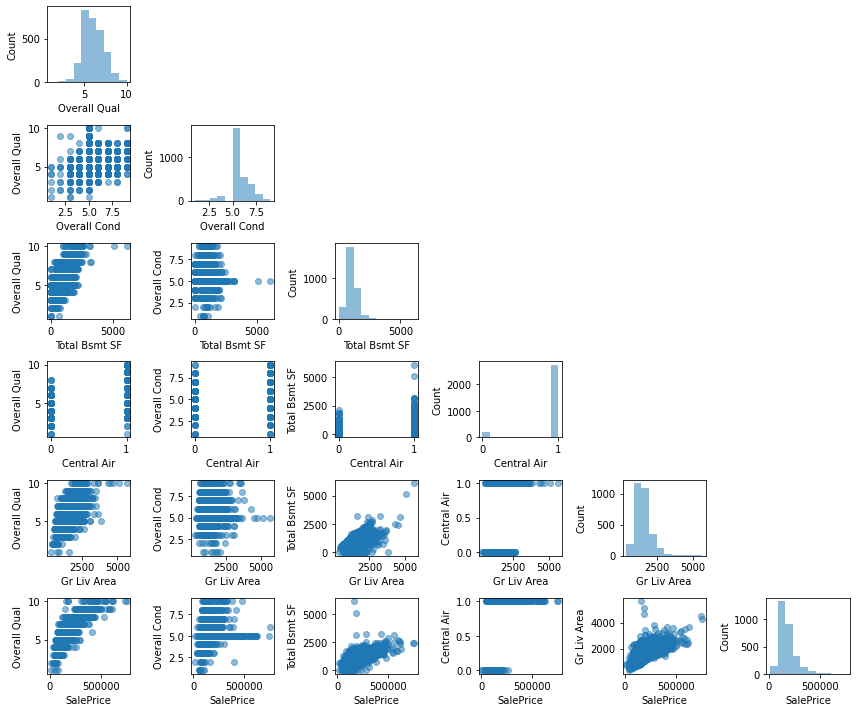

In [6]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values, figsize=(12, 10),
                  names=df.columns, alpha=0.5)
plt.tight_layout()

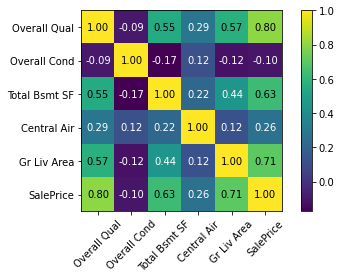

In [7]:
import numpy as np
from mlxtend.plotting import heatmap


cm = np.corrcoef(df.values.T)
# hm = heatmap(cm)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

<AxesSubplot:>

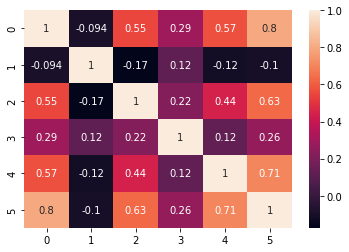

In [8]:
import seaborn as sns

sns.heatmap(cm, annot=True)

In [9]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        return self.net_input(X)
    
    

In [10]:
import random
import numpy as np


X = np.array([[1, 1, 3]])

rgen = np.random.RandomState(1)
w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])

print(rgen)
print(w_)

RandomState(MT19937)
[ 0.01624345 -0.00611756 -0.00528172]


In [11]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

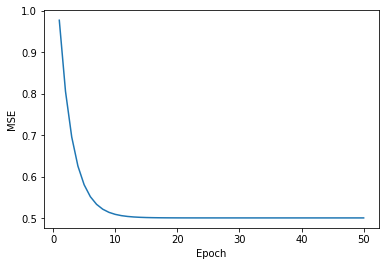

In [12]:
plt.plot(range(1, lr.n_iter + 1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

In [13]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

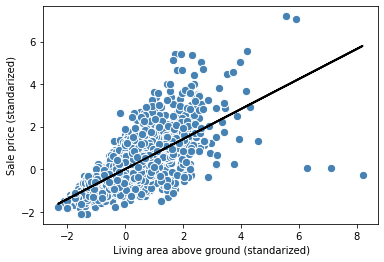

In [14]:
lin_regplot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (standarized)')
plt.ylabel('Sale price (standarized)')
plt.show()

In [15]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))

print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')


Sales price: $292507.07


In [16]:
print(f'Slope: {lr.w_[0]:.3f}')

Slope: 0.707


In [17]:
print(f'Intercept: {lr.b_[0]:.3f}')

Intercept: -0.000


# Estimating the coefficient of a regression model via scikit-learn

In [18]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')

Slope: 111.666


In [19]:
print(f'Intercept: {slr.intercept_:.3f}')

Intercept: 13342.979


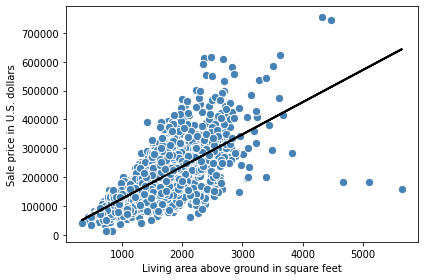

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.tight_layout()
plt.show()


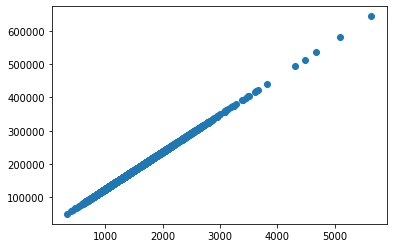

In [21]:
plt.scatter(X, y_pred) #y
plt.show()

In [22]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))
print(f'Slope: {w[1]:.3f}')

Slope: 111.666


print(f'Intercept: {w[0]:.3f}')

# Fitting a robust regression model using RANSAC

In [24]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100, # default
    min_samples=0.95,
    residual_threshold=None, # default
    random_state=123)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

In [ ]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')